# Distribution of True Stellar Rotational Velocities

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps

import scipy.stats as stats
import scipy.integrate as integrate
from scipy.interpolate import CubicSpline

%matplotlib inline

Where the variable $x \equiv v$ is the true rotational velocity, and $y \equiv v \sin i$ is the projected rotational velocity. The variable $x$ follows a distribution $f_X(x)$, and the variable $y$ follows a distribution $f_Y(y)$. The parameter $\alpha$ is a constant that depends on the specific characteristics of the system being modeled.

The function designed in this proyect is

$$f_Y(y) = \int_y^\infty \frac{y^{2\alpha+1}}{x^{2\alpha+1}} \frac{1}{\sqrt{x^2 + y^2}} f_X(x) \, dx$$

We will begin with set of field stars, called **Geneva** with, known projected rotational velocities, and we will assume a distribution for the true rotational velocities. This data set was obtained from [J. Holmberg et al. 2009](https://ui.adsabs.harvard.edu/abs/2009A%26A...501..941H/abstract) and contains 11818 projected rotational velocities of F and G dwarf stars in the solar neighborhood.


In [67]:
# Load the datasets
gendata = pd.read_csv('data/geneve.dat', header=None)
gendata.columns = ['vsini']
print("Number of stars:",gendata.shape[0])

Number of stars: 11818


By expert knowledge, we know that any star has a rotational velocity $v \leq 0$ km/s. Therefore, we have to remove the values where this condition is met.

In [3]:
print("Gendata vsini <= 0 count:",gendata[gendata.vsini <=0].vsini.count())
gendata = gendata[gendata.vsini > 0]

Gendata vsini <= 0 count: 133


First we will create the Kernel Density Estimation (KDE) function for the given $v \sin{i}$ data points, that represents the projected rotational velocities of stars. The KDE function will help us estimate the probability density function of the data $f_Y(y)$.

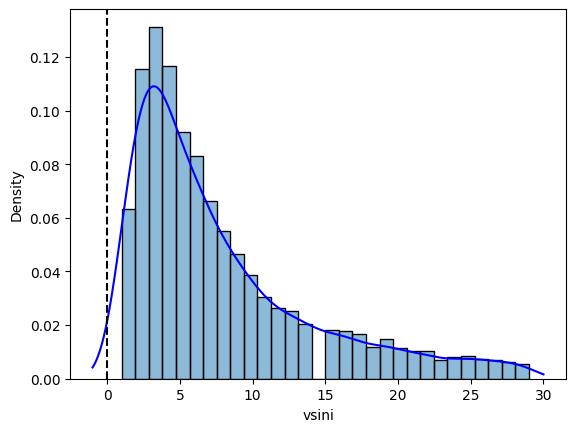

In [4]:
kde = stats.gaussian_kde(gendata.vsini, bw_method='silverman')
vsinimax, vsinimin = gendata.vsini.max(), gendata.vsini.min()
vsinirange = np.linspace(vsinimin-2, vsinimax+1, 1000)

fig, ax = plt.subplots()

ax.plot(vsinirange, kde(vsinirange), label='Gendata KDE', color='blue')
sns.histplot(gendata.vsini, bins=30, stat='density', alpha=0.5, label='Gendata Histogram', ax=ax)
ax.axvline(0.0, color='black', linestyle='--')

As we can see in the KDE plot below, the projected rotational velocities are distributed between $0$ km/s and approximately $30$ km/s, with a peak around $3$ km/s. But the KDE does not begins exactly at $0$ km/s, so we will use a technique called "reflection" to ensure that the KDE starts at $0$ km/s. This technique involves reflecting the data points around the boundary (0 km/s in this case) to create a symmetric distribution.

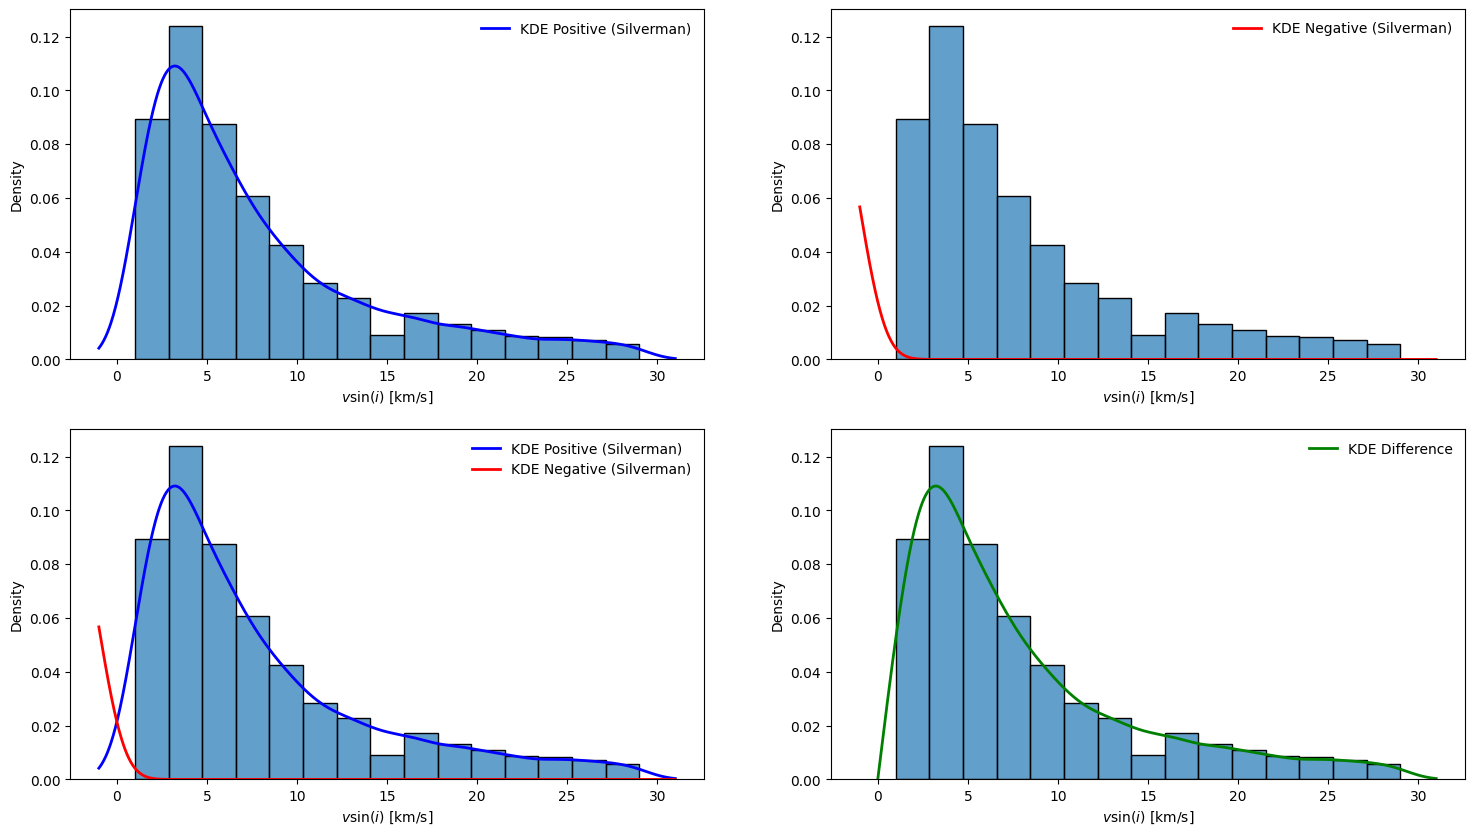

In [5]:
kdeplus = stats.gaussian_kde(dataset=gendata.vsini,bw_method='silverman')
kdenegs = stats.gaussian_kde(dataset=-gendata.vsini,bw_method='silverman')

vsinimax, vsinimin = max(gendata.vsini)+2, min(gendata.vsini-2)
vsinirange = np.linspace(start=vsinimin, stop=vsinimax, num=1000)
kdeplus_values = kdeplus.evaluate(vsinirange)
kdenegs_values = kdenegs.evaluate(vsinirange)

# This function computes the difference between the two gaussian KDEs.
# This KDE represents the estimated vsini distribution corrected for
# the observational bias towards positive values. Taking the negative
# KDE into account helps to mitigate the skewness introduced by the
# fact that vsini values cannot be negative.
kde = lambda x: kdeplus.evaluate(x) - kdenegs.evaluate(x)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

for i, ax in enumerate(axes.flatten()):
    sns.histplot(
    data=gendata,
    x='vsini',
    bins=15,
    stat='density',
    edgecolor='black',
    alpha=0.7,
    ax=ax
    )
    ax.set_ylabel('Density')
    ax.set_xlabel(r'$v\sin(i)$ [km/s]')
    ax.set_ylim(0, None)
    if i == 0:
        ax.plot(vsinirange,kdeplus_values,color='blue',lw=2,label='KDE Positive (Silverman)')
    elif i == 1:
        ax.plot(vsinirange,kdenegs_values,color='red',lw=2,label='KDE Negative (Silverman)')
    elif i == 2:
        ax.plot(vsinirange,kdeplus_values,color='blue',lw=2,label='KDE Positive (Silverman)')
        ax.plot(vsinirange,kdenegs_values,color='red',lw=2,label='KDE Negative (Silverman)')
    else:
        ax.plot(vsinirange,kde(vsinirange),color='green',lw=2,label='KDE Difference')
        
    ax.legend(frameon=False)
        
plt.show()

Now we will create a meshgrid for the variables $x$ and $y$. The meshgrid will allow us to evaluate the integral for a range of values of $x$ and $y$.

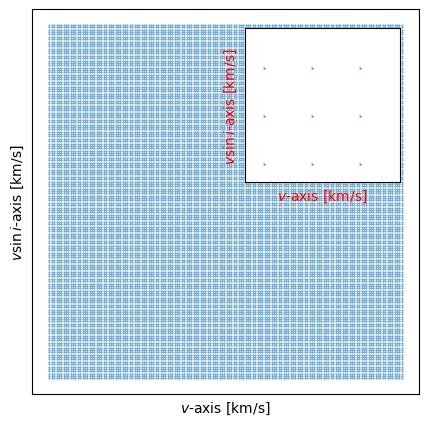

In [6]:
N = 150
a, b = 0.1, gendata.vsini.max()+5
dx = (b - a)/N
dy = (b - a + dx/2)/N
x = a + dx * (np.arange(N)-0.05)
y = a + dy * (np.arange(N)-0.05)

xx, yy = np.meshgrid(x, y)

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(xx, yy, s=1, marker='.', alpha=0.7)
ax.axis('equal')
ax.set_xlabel(r'$v$-axis [km/s]')
ax.set_ylabel(r'$v\sin{i}$-axis [km/s]')
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticklabels([])
axins = ax.inset_axes([0.55, 0.55, 0.4, 0.4], xlim=(0, dx+0.5), ylim=(0, dy+0.5))
axins.scatter(xx, yy, s=1, marker='.')
axins.set_xlabel(r'$v$-axis [km/s]',color='red')
axins.set_ylabel(r'$v\sin{i}$-axis [km/s]', color='red')
axins.set_yticklabels([])
axins.set_xticklabels([])
axins.set_xticks([])
axins.set_yticks([])
plt.show()

Recall the objective equation:
$$f_Y(y) = c_\alpha\int_y^\infty \frac{y^{2\alpha+1}}{x^{2\alpha+1}} \frac{1}{\sqrt{x^2 - y^2}} f_X(x) \, dx$$

We caan use a matrix form to represent the integral equation. We will discretize the integral by evaluating it at the meshgrid points.

$$\underbrace{f_Y(y)}_{\mathbf{Y}} = \underbrace{c_\alpha\int_y^\infty dx \frac{y^{2\alpha+1}}{x^{2\alpha+1}} \frac{1}{\sqrt{x^2 - y^2}}}_{\mathbf{A}}  \, \underbrace{f_X(x)}_{\mathbf{X}} $$

Now we will using the matrix form for our objetive equation: 
$$Y = AX$$

where $Y = f_Y(y)$, $X = f_X(x)$, and $A$ is the matrix that contains the values of the integrand evaluated at the meshgrid points.

Now we will solve for $X$ using the pseudo-inverse of matrix $A$:
$$X = A^{-1}Y$$

First we will create the A matrix by evaluating the integrand at the meshgrid points. Then we will compute the pseudo-inverse of matrix $A$ using the Singular Value Decomposition (SVD) method. So we also create a vector of $\alpha$ values to evaluate the integrand for different $\alpha$ values.

Finally, we will multiply the pseudo-inverse of matrix $A$ with the KDE values $Y$ to obtain the estimated distribution of true stellar rotational velocities $X = f_X(x)$.

In [40]:
# Create an array of alpha values
alphas = np.linspace(-0.5, 2.0, 20)
alphas = alphas[:, None, None]

# This mask is created to obtain just real values where y=vsin(i)<=v=x
mask = yy < xx

ratio_grid = np.zeros_like(xx)
geom_grid  = np.zeros_like(xx)

ratio_grid[mask] = (yy[mask]/xx[mask])
geom_grid[mask]  = 1/np.sqrt(xx[mask]**2-yy[mask]**2)

A = (ratio_grid[None, :, :]**(2*alphas+1)) * geom_grid[None, :, :]
print("A shape:", A.shape)

A shape: (20, 150, 150)


Now we will obtain the _Probability Density Function_ (PDF) of the projected rotational velocities $f_Y(y)$ using the KDE function created earlier. Then, we will use the pseudo-inverse of matrix $A$ to compute the estimated distribution of true stellar rotational velocities $f_X(x)$.

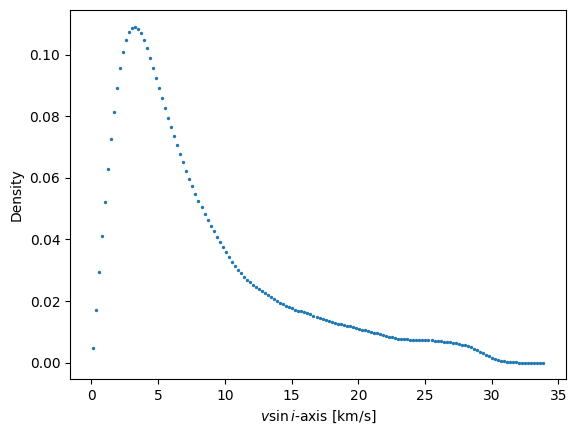

In [41]:
fyy = kde(y)
fig, ax = plt.subplots()
ax.scatter(y.flatten(), fyy, s=2)
ax.set_xlabel(r'$v\sin{i}$-axis [km/s]')
ax.set_ylabel('Density')
plt.show()

Now we want to regularize the solution to avoid overfitting. We will use Tikhonov regularization, which adds a penalty term to the least squares solution. The regularized solution is given by:
$$\hat X = (A^\top A+\lambda I)^{-1}A^\top Y$$

where $\lambda$ is the regularization parameter, and $I$ is the identity matrix. In this case, we will set $\lambda = 0.01$.

In [42]:
# Solve the regularized least squares problem following Tikhonov regularization
# for each alpha value. Finding fxx such that:
# minimize || A * fxx - fyy ||^2 + lambda * || fxx ||^2
AT = A.transpose(0, 2, 1)

# Tikhonov regularization parameter
tiklambda = 1

# Identity matrix
Idnt = np.eye(N)

LHS = AT @ A + tiklambda * Idnt[None, ...]
RHS = AT @ fyy

# Solve for fxx, the estimated distribution of v.
fxx = np.linalg.solve(LHS, RHS[..., None]).squeeze()

Now we want to normalize the estimated distribution of true stellar rotational velocities $f_X(x)$ so that it integrates to 1 over the range of $x$. This is done by dividing the estimated distribution by its integral over the range of $x$.

In [43]:
# Interpolate fxx for smoother curves
fxx_inter = CubicSpline(x=x, y=fxx, axis=1)(x)
# Normalize each fxx_inter row to ensure it integrates to 1
cte = integrate.simpson(fxx_inter, x, axis=1)
fxx_inter = fxx_inter / cte[:, None]

print("Shape after interpolation and normalization:", fxx_inter.shape)
print("Integration check (should be close to 1):", np.round(integrate.simpson(fxx_inter, x, axis=1).sum()/len(alphas),2))

Shape after interpolation and normalization: (20, 150)
Integration check (should be close to 1): 1.0


Now we want to reconstruct the projected rotational velocities distribution $f_Y(y)$ using the estimated true rotational velocities distribution $f_X(x)$. Integrating the estimated $f_X(x)$ back into the original integral equation should yield a distribution that closely matches the original KDE of $f_Y(y)$.

In [44]:
# Reconstruct fyy from fxx_inter and A, using numerical integration
fyy_recons = integrate.trapezoid(A * fxx_inter[:, None, :],x=x,axis=2)

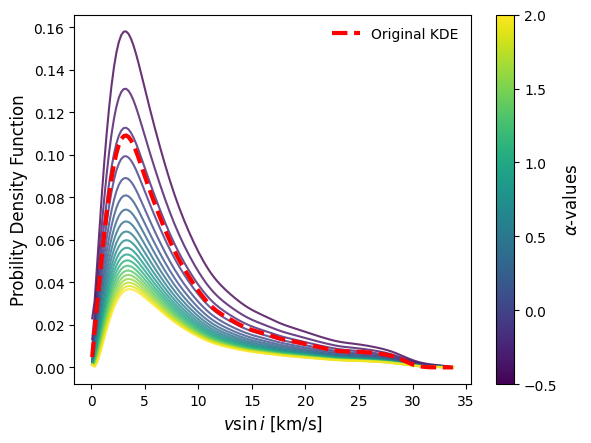

In [45]:
cmap = colormaps.get_cmap('viridis')
norm = plt.Normalize(vmin=alphas.min(), vmax=alphas.max())

# 2. Crear el objeto ScalarMappable que usará el colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(alphas) # Le decimos que valores numéricos representan el color

fig, ax = plt.subplots()
for i in range(len(alphas)):
    line_color = cmap(norm(alphas[i])).flatten()
    ax.plot(x, fyy_recons[i,:], color=line_color, alpha=0.8)
    
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'$\alpha$-values', fontsize=12)
ax.plot(x, fyy, 'r--', lw=3, label='Original KDE')
ax.set_xlabel(r'$v\sin{i}$ [km/s]', fontsize=12)
ax.set_ylabel('Probility Density Function', fontsize=12)
plt.legend(frameon=False)
plt.show()

For see what is the best value of the parameter $\alpha$, we will use the RMSE (Root Mean Square Error) metric to compare the reconstructed $f_Y(y)$ with the original KDE of $f_Y(y)$. The value of $\alpha$ that minimizes the RMSE will be considered the best fit for the data.

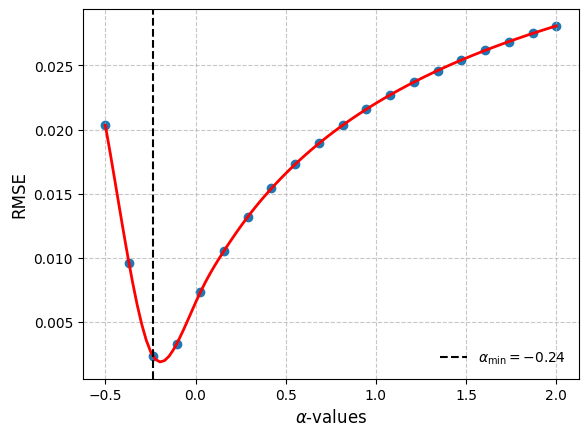

In [69]:
rmse = np.sqrt(np.mean((fyy_recons - fyy[None, :])**2, axis=1))
alins = np.linspace(alphas.min(), alphas.max(), 100)
rmse_smooth = CubicSpline(alphas.flatten(), rmse)(alins)

minidx = np.argmin(rmse)
fig, ax = plt.subplots()
ax.scatter(alphas.flatten(), rmse)
ax.plot(alins, rmse_smooth, 'r-', lw=2)
ax.set_xlabel(r'$\alpha$-values', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.axvline(
    alphas.flatten()[minidx], 
    color='black', 
    linestyle='--', 
    label=f'$\\alpha_\\text{{min}}={alphas.flatten()[minidx]:.2f}$' 
)
ax.legend(frameon=False)
ax.grid(ls='--', alpha=0.7)
plt.savefig('results/rmse_vs_alpha_geneve.png', dpi=300, bbox_inches='tight')
plt.show()

Finally, we will plot the estimated distribution of true stellar rotational velocities $f_X(x)$ for the best fit value of $\alpha$. This plot will show how the true rotational velocities are distributed based on the projected rotational velocities data and the chosen model.

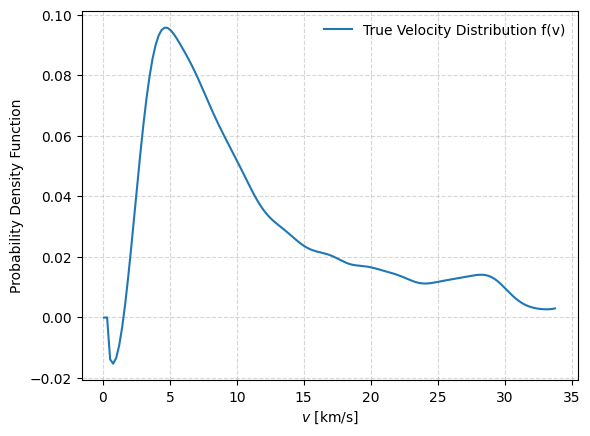

In [68]:
fxx_opt = fxx_inter[minidx, :]

fig, ax = plt.subplots()
ax.plot(x, fxx_opt, label='True Velocity Distribution f(v)')
ax.set_xlabel(r'$v$ [km/s]')
ax.set_ylabel('Probability Density Function')
ax.legend(frameon=False)
ax.grid(ls='--', alpha=0.5)
#ax.set_ylim(0, None)
plt.savefig('results/true_velocity_distribution_geneve.png', dpi=300, bbox_inches='tight')

plt.show()
        

I way to obtain a stable solution is to use Tikhonov regularization, where $\lambda$ is a regularization parameter that controls the trade-off between fitting the data and smoothing the solution. The term $\lambda I$ is added to the matrix $A^\top A$ to ensure that it is invertible and to stabilize the solution. 

For this L-curve method is used to find the optimal value of $\lambda$. The L-curve is a plot of the norm of the solution $\|X\|$ versus the norm of the residual $\|AX - Y\|$ for different values of $\lambda$. The corner of the L-curve corresponds to the optimal value of $\lambda$ that balances the trade-off between fitting the data and smoothing the solution.


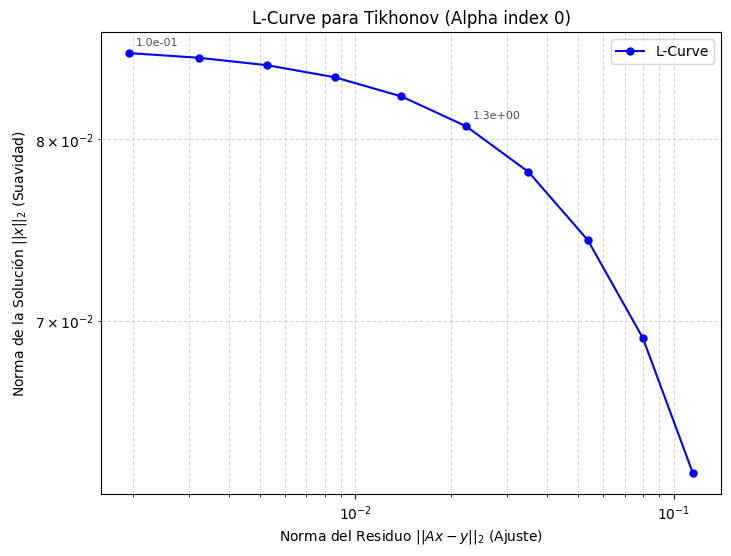

In [25]:
tiklambdas = np.logspace(-1, 1, 10)
idx_alpha = 0

A_matrix = A[idx_alpha] # Matrix (150, 150)
y_vector = fyy          # Vector (150,)
N = A_matrix.shape[1]   # 150

norm_residual = []  # ||A * fxx - fyy||
norm_solution = []  # ||fxx||

AT   = A_matrix.T
ATy  = AT @ y_vector
ATA  = AT @ A_matrix
Idnt = np.eye(N)

for lam in tiklambdas:
    LHS = ATA + lam * Idnt
    fxx_lam = np.linalg.solve(LHS, ATy)
    
    # Res: How far is A*fxx from y
    res = np.linalg.norm(A_matrix @ fxx_lam - y_vector)
    
    # Sol: How big/complex is the solution fxx_lam
    sol = np.linalg.norm(fxx_lam)
    
    norm_residual.append(np.linalg.norm(res))
    norm_solution.append(np.linalg.norm(sol))

norm_residual = np.array(norm_residual)
norm_solution = np.array(norm_solution)

plt.figure(figsize=(8, 6))

# Graficar la curva (log-log)
plt.loglog(norm_residual, norm_solution, 'b.-', markersize=10, label='L-Curve')

# Anotar algunos valores de lambda para referencia
# Tomamos índices espaciados para no saturar el gráfico
for i in range(0, len(tiklambdas), 5):
    plt.annotate(f'{tiklambdas[i]:.1e}', 
                 (norm_residual[i], norm_solution[i]),
                 textcoords="offset points", 
                 xytext=(5, 5), 
                 fontsize=8,
                 alpha=0.7)

plt.title(f"L-Curve para Tikhonov (Alpha index {idx_alpha})")
plt.xlabel(r"Norma del Residuo $||Ax - y||_2$ (Ajuste)")
plt.ylabel(r"Norma de la Solución $||x||_2$ (Suavidad)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()